#EXP 5
Design and implement Multiple Object Tracking using OpenCV

In [ ]:
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2025-03-07 17:50:04--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12231 (12K) [text/plain]
Saving to: ‘yolov4.cfg’

yolov4.cfg          100%[===================>]  11.94K  --.-KB/s    in 0s      

2025-03-07 17:50:04 (88.7 MB/s) - ‘yolov4.cfg’ saved [12231/12231]

--2025-03-07 17:50:04--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/75388965/ba4b6380-889c-11ea-9751-f994f596179

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

Load the video file

In [ ]:
video_path = '/content/input_vid.mp4'
cap = cv2.VideoCapture(video_path)

#Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

Enter the frame number to analyze (0 to 187): 186
Total frames in the video: 188
Displaying detected objects for frame 186:


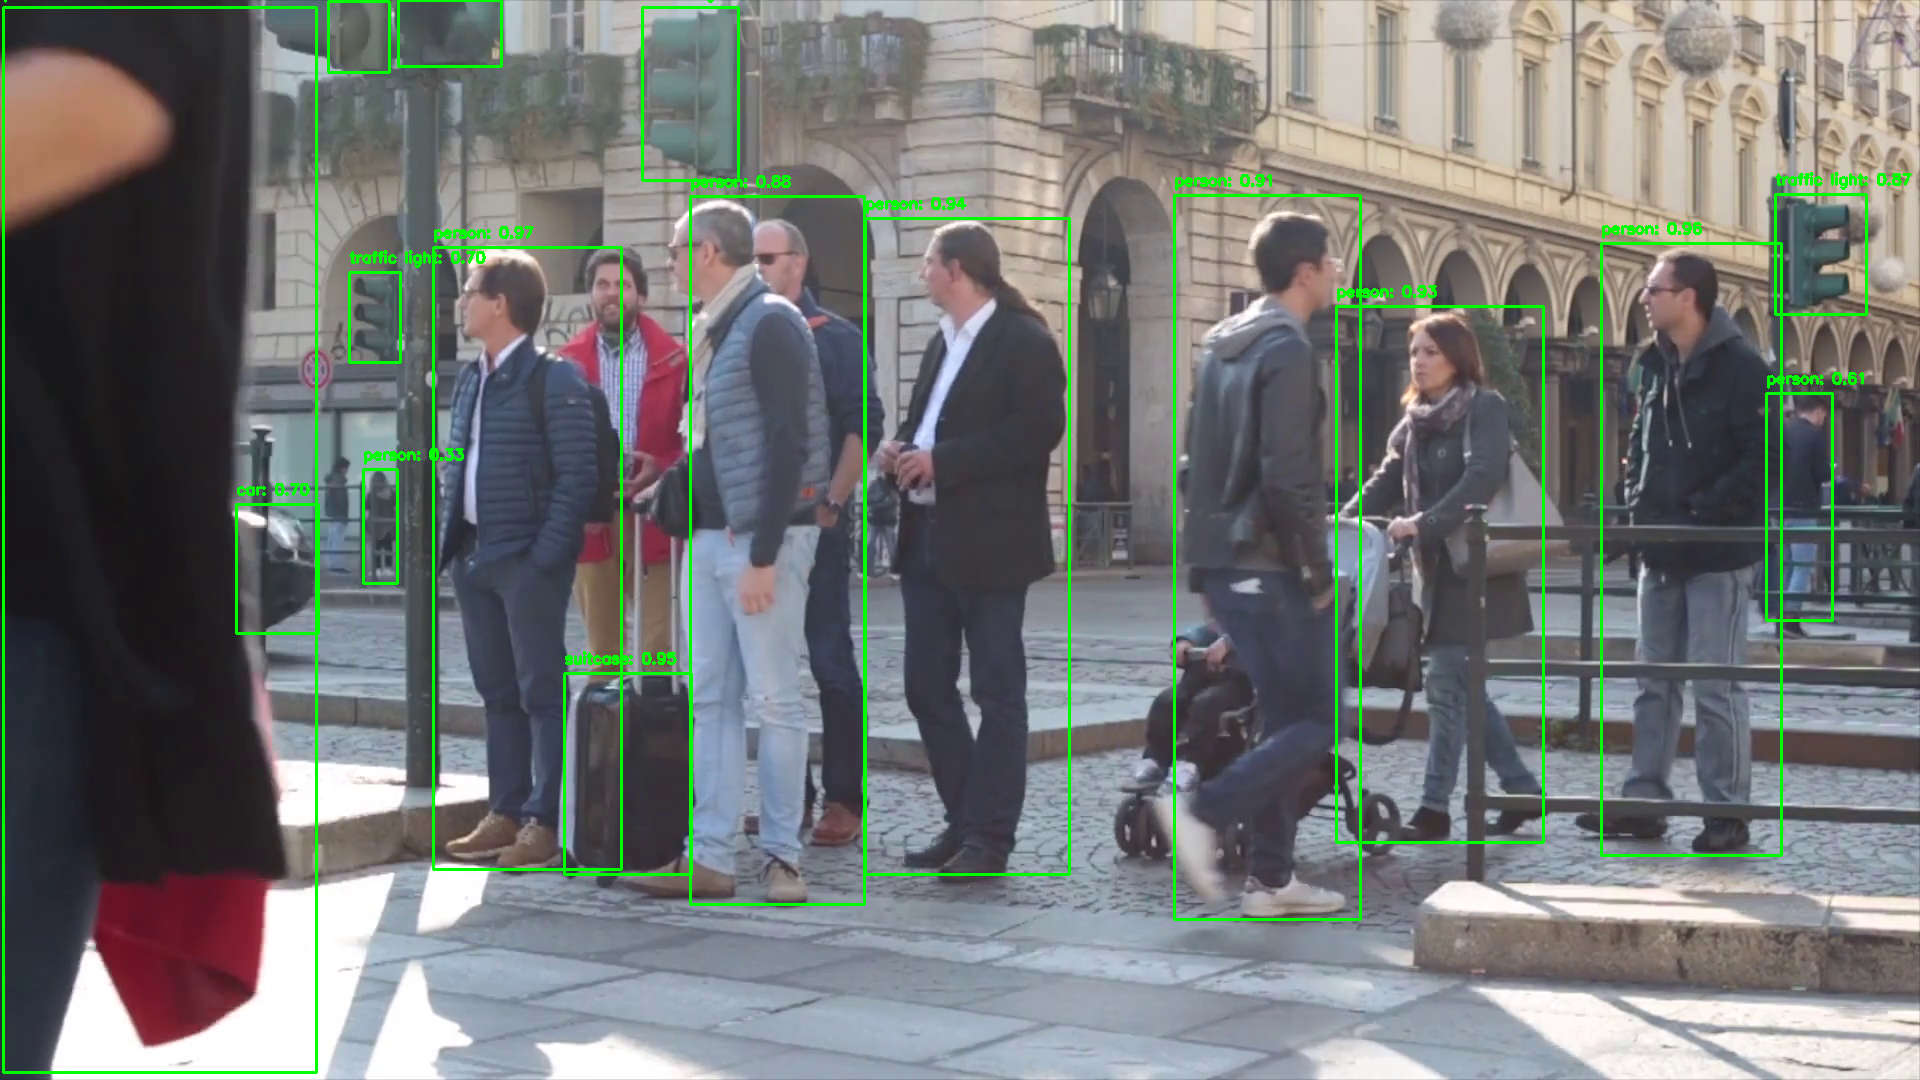

In [ ]:
import cv2
import numpy as np

# Load YOLO model
def load_yolo():
    net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")  # Use full model for better detection
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Use CUDA if available

    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, classes, output_layers

# Get total frames in the video
def get_total_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

# Object detection using YOLO
def detect_objects(frame, net, output_layers):
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    return net.forward(output_layers), width, height

# Draw labels on the detected objects
def draw_labels(outputs, frame, classes, width, height):
    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:  # Lower threshold to detect smaller objects
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.2)  # Adjusted NMS

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return frame

# Process the video to analyze a specific frame
def process_video(video_path, frame_number):
    net, classes, output_layers = load_yolo()
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in the video: {total_frames}")

    if frame_number >= total_frames or frame_number < 0:
        print(f"Invalid frame number! Please enter a number between 0 and {total_frames - 1}.")
        cap.release()
        return

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: Could not retrieve the specified frame!")
        return

    # Detect objects
    outputs, width, height = detect_objects(frame, net, output_layers)

    # Draw the labels on the frame
    processed_frame = draw_labels(outputs, frame, classes, width, height)

    print(f"Displaying detected objects for frame {frame_number}:")
    # For Google Colab use cv2_imshow(processed_frame)
    cv2_imshow(processed_frame)


if __name__ == "__main__":
    video_path = "/content/input_vid.mp4"  # Replace with actual video file path
    total_frames = get_total_frames(video_path)
    frame_number = int(input(f"Enter the frame number to analyze (0 to {total_frames - 1}): "))
    process_video(video_path, frame_number)
